In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import random
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

# Data Set Information:

a client is a meal delivery company which operates in multiple `cities`. They have various `fulfillment centers` in these cities for dispatching `meal orders` to their customers. They want us to help these centers with demand forecasting for upcoming weeks so that these centers will plan the `stock` of `raw materials` accordingly.

The replenishment of majority of raw materials is done on `weekly basis` and since the raw material is likely to decay or go bad quickly, the procurement planning is of utmost importance.
Secondly, staffing of the centers is also one area where in accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:

Historical data of demand for a product-center combination (Weeks: 1 to 145)
Product(Meal) features such as category, sub-category, current price and discount
Information for fulfillment center like center area, city information etc.


## Attribute Information:

Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable


- Variable Definition
- id Unique ID
- week Week No
- center_id Unique ID for fulfillment center
- meal_id Unique ID for Meal
- checkout_price Final price including discount, taxes & delivery charges
- base_price Base price of the meal
- emailer_for_promotion Emailer sent for promotion of meal
- homepage_featured Meal featured at homepage
- num_orders (Target) Orders Count


- fulfilment_center_info.csv: Contains information for each fulfilment center


- Variable Definition
- center_id Unique ID for fulfillment center
- city_code Unique code for city
- region_code Unique code for region
- center_type Anonymized center type
- op_area Area of operation (in km^2)


- meal_info.csv: Contains information for each meal being served


- Variable Definition
- meal_id Unique ID for the meal
- category Type of meal (beverages/snacks/soupsâ€¦.)
- cuisine Meal cuisine (Indian/Italian/â€¦)

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
fulfil = pd.read_csv('fulfilment_center_info.csv')
meal = pd.read_csv('meal_info.csv')

In [3]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [4]:
meal.shape

(51, 3)

In [5]:
train.head(10)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
5,1270037,1,55,1248,251.23,252.23,0,0,28
6,1191377,1,55,1778,183.36,184.36,0,0,190
7,1499955,1,55,1062,182.36,183.36,0,0,391
8,1025244,1,55,2707,193.06,192.06,0,0,472
9,1054194,1,55,1207,325.92,384.18,0,1,676


In [6]:
train.shape

(456548, 9)

In [7]:
fulfil.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


to reduce the amount of columns we are working with we are going to merge them all based on ids that are present in the train dataset for each of the sub-datasets

In [8]:
train = pd.merge(meal,train,on='meal_id')
train = pd.merge(fulfil,train,on="center_id")
test = pd.merge(meal,test,on='meal_id')
test = pd.merge(fulfil,test,on="center_id")

In [9]:
train.head()

,center_id,city_code,region_code,center_type,op_area,meal_id,category,cuisine,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1103215,1,136.83,136.83,0,0,959
1,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1091356,2,133.86,135.86,0,0,1054
2,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1195933,3,135.86,133.86,0,0,891
3,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1425602,4,134.86,135.86,0,0,1107
4,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1249127,5,146.53,146.53,0,0,919


In [10]:
train.shape

(456548, 15)

In [11]:
test.shape

(32573, 14)

In [12]:
train.duplicated().sum()

0

In [13]:
train.isna().sum()

center_id                0
city_code                0
region_code              0
center_type              0
op_area                  0
meal_id                  0
category                 0
cuisine                  0
id                       0
week                     0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [14]:
train

,center_id,city_code,region_code,center_type,op_area,meal_id,category,cuisine,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1103215,1,136.83,136.83,0,0,959
1,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1091356,2,133.86,135.86,0,0,1054
2,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1195933,3,135.86,133.86,0,0,891
3,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1425602,4,134.86,135.86,0,0,1107
4,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1249127,5,146.53,146.53,0,0,919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,51,638,56,TYPE_A,7.0,1445,Seafood,Continental,1308117,141,728.53,727.53,0,0,27
456544,51,638,56,TYPE_A,7.0,1445,Seafood,Continental,1467391,142,728.53,728.53,0,0,40
456545,51,638,56,TYPE_A,7.0,1445,Seafood,Continental,1472391,143,485.03,727.53,0,1,204
456546,51,638,56,TYPE_A,7.0,1445,Seafood,Continental,1001628,144,484.03,728.53,1,1,337


In [15]:
test

,center_id,city_code,region_code,center_type,op_area,meal_id,category,cuisine,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1098228,146,158.17,157.17,0,0
1,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1080847,147,158.14,158.14,0,0
2,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1064602,148,157.17,158.17,0,0
3,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1093227,149,157.17,158.17,0,0
4,11,679,56,TYPE_A,3.7,1885,Beverages,Thai,1177861,150,159.14,158.14,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32568,51,638,56,TYPE_A,7.0,1445,Seafood,Continental,1463347,151,728.53,726.53,0,0
32569,51,638,56,TYPE_A,7.0,1445,Seafood,Continental,1211180,152,727.53,727.53,0,0
32570,51,638,56,TYPE_A,7.0,1445,Seafood,Continental,1004884,153,727.53,726.53,0,0
32571,51,638,56,TYPE_A,7.0,1445,Seafood,Continental,1292684,154,727.53,727.53,0,0


In [16]:
test.isna().sum()

center_id                0
city_code                0
region_code              0
center_type              0
op_area                  0
meal_id                  0
category                 0
cuisine                  0
id                       0
week                     0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [17]:
cols=['center_id','meal_id','region_code','cuisine','city_code','center_type','category']
test[cols] = test[cols].astype('category')
train[cols] = train[cols].astype('category')
print(train.dtypes)
print(test.dtypes)

center_id                category
city_code                category
region_code              category
center_type              category
op_area                   float64
meal_id                  category
category                 category
cuisine                  category
id                          int64
week                        int64
checkout_price            float64
base_price                float64
emailer_for_promotion       int64
homepage_featured           int64
num_orders                  int64
dtype: object
center_id                category
city_code                category
region_code              category
center_type              category
op_area                   float64
meal_id                  category
category                 category
cuisine                  category
id                          int64
week                        int64
checkout_price            float64
base_price                float64
emailer_for_promotion       int64
homepage_featured           int64


In [18]:
train.describe()

,op_area,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,456548.000000,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,4.083590,1.250096e+06,74.768771,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.091686,1.443548e+05,41.524956,152.939723,160.715914,0.273069,0.31189,395.922798
min,0.900000,1.000000e+06,1.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,3.600000,1.124999e+06,39.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,4.000000,1.250184e+06,76.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,4.500000,1.375140e+06,111.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,7.000000,1.499999e+06,145.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


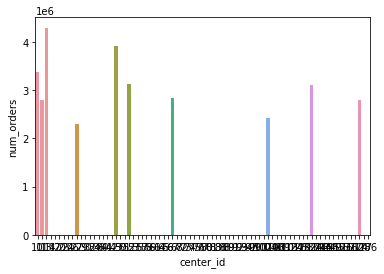

In [19]:
center=train.groupby("center_id",as_index=False).sum()
center=center[["center_id","num_orders"]].sort_values(by="num_orders",ascending=False).head(10)
fig=sns.barplot(x=center["center_id"],y=center["num_orders"])


In [20]:
train['category'].value_counts()

Beverages       127890
Rice Bowl        33408
Sandwich         33291
Pizza            33138
Starters         29941
Other Snacks     29379
Desert           29294
Salad            28559
Pasta            27694
Seafood          26916
Biryani          20614
Extras           13562
Soup             12675
Fish             10187
Name: category, dtype: int64

Text(0.5, 0.98, 'popular food categories')

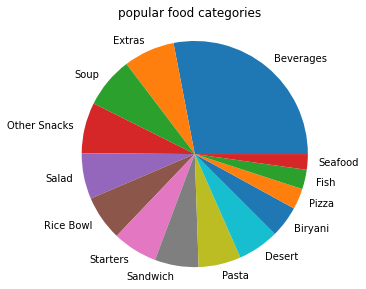

In [21]:
plt.pie(train['category'].value_counts(),labels=train['category'].unique(),radius=1.3)
plt.suptitle('popular food categories', horizontalalignment = 'center' , verticalalignment='baseline')

Text(0.5, 0.98, 'popular cusines')

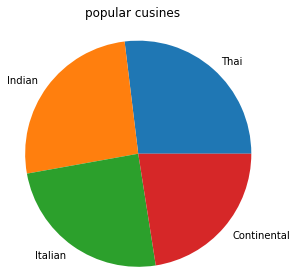

In [22]:
plt.pie(train['cuisine'].value_counts(),labels=train['cuisine'].unique(),radius=1.3 )
plt.suptitle('popular cusines', horizontalalignment = 'center' , verticalalignment='baseline')

<AxesSubplot:>

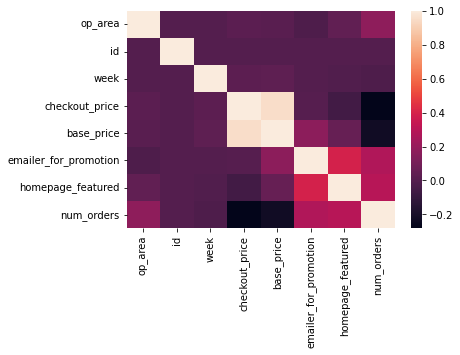

In [23]:
sns.heatmap(train.corr())

In [24]:
cat = train.select_dtypes(include='category').columns.values.tolist()
cat

['center_id',
 'city_code',
 'region_code',
 'center_type',
 'meal_id',
 'category',
 'cuisine']

In [25]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(train[cat])
encoder.fit(test[cat])
encod_colster = pd.DataFrame(encoder.transform(train[cat]),columns=encoder.get_feature_names())
encod_colstes = pd.DataFrame(encoder.transform(test[cat]),columns=encoder.get_feature_names())
train = train.drop(columns=cat)
for cols in encod_colster.columns:
    train[cols] = encod_colster[cols]
for cols in encod_colstes.columns:
    test[cols] = encod_colstes[cols]

In [26]:
# Train-Validation Data Split
y = train[["num_orders"]]
x= train.drop(["num_orders","id","base_price"],axis = 1)
testfen = test.drop(["id","base_price"],axis = 1)

In [27]:
x= x.replace((np.inf, -np.inf, np.nan))

In [28]:
x

,op_area,week,checkout_price,emailer_for_promotion,homepage_featured,x0_10,x0_11,x0_13,x0_14,x0_17,...,x5_Rice Bowl,x5_Salad,x5_Sandwich,x5_Seafood,x5_Soup,x5_Starters,x6_Continental,x6_Indian,x6_Italian,x6_Thai
0,3.7,1,136.83,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.7,2,133.86,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.7,3,135.86,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.7,4,134.86,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.7,5,146.53,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,7.0,141,728.53,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
456544,7.0,142,728.53,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
456545,7.0,143,485.03,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
456546,7.0,144,484.03,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
y

,num_orders
0,959
1,1054
2,891
3,1107
4,919
...,...
456543,27
456544,40
456545,204
456546,337


In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

In [31]:
LinReg = make_pipeline(StandardScaler(),LinearRegression())
LinReg.fit(X_train, y_train)
y_pred = LinReg.predict(X_test)
y_pred[y_pred<0] = 0 

In [32]:
print('mean_squared_error : ', mean_squared_error(y_test, y_pred))
print('mean_absolute_error : ', mean_absolute_error(y_test, y_pred))
print('root mean_squared_error : ',np.sqrt( mean_squared_error(y_test, y_pred)))
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(y_test,y_pred)))

mean_squared_error :  84507.04902830576
mean_absolute_error :  143.8323905410014
root mean_squared_error :  290.70096151940356
RMSLE: 173.5633851795657


In [ ]:
KNN = make_pipeline(StandardScaler(),KNeighborsRegressor())
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
y_pred[y_pred<0] = 0

In [ ]:
print ("The MSE is:",format(np.power(y_pred.predict(X),4).mean()))

In [ ]:
DT = DecisionTreeRegressor()
DT.fit(X_train, y_train)
y_pred = DT.predict(X_val)
y_pred[y_pred<0] = 0
from sklearn import metrics
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(y_test, y_pred)))

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LinReg,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes =[0.2,0.4,0.6,0.8,1,],
   
)

train_mean = -train_scores.mean(axis=1)
train_std = -train_scores.std(axis=1)

test_mean = -test_scores.mean(axis=1)
test_std = -test_scores.std (axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Error")
plt.legend(loc="best")

plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=KNN,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes =[0.2,0.4,0.6,0.8,1,],
   
)

train_mean = -train_scores.mean(axis=1)
train_std = -train_scores.std(axis=1)

test_mean = -test_scores.mean(axis=1)
test_std = -test_scores.std (axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")



plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Error")
plt.legend(loc="best")

plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=DT,
    X=X,
    y=y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes =[0.2,0.4,0.6,0.8,1,],
   
)

train_mean = -train_scores.mean(axis=1)
train_std = -train_scores.std(axis=1)

test_mean = -test_scores.mean(axis=1)
test_std = -test_scores.std (axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")



plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Error")
plt.legend(loc="best")

plt.show()